<a href="https://colab.research.google.com/github/petarSuki/Exercise/blob/main/Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import standard libraries
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
#Import tensorflow libraries - FUNCTIONAL API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [ ]:
#Avoid Out of Memory error by settting GPU Memory Consuption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
#Uncompress TAR GZ Labelled facces in the wild dataset
!tar -xf /content/drive/MyDrive/lfw.tgz

In [ ]:
#Move Labelled faces in the wild images to the following repository data/negative
for directory in os.listdir('lfw'):
  for file in os.listdir(os.path.join('lfw', directory)):
    EX_PATH = os.path.join('lfw', directory, file)
    NEW_PATH = os.path.join(NEG_PATH, file)
    os.replace(EX_PATH, NEW_PATH)

In [ ]:
#Import uuid library to generate unique image names
import uuid

In [ ]:
os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))

'data/anchor/9cc3e1fe-5a2d-11ef-8c8c-0242ac1c000c.jpg'

In [ ]:
def data_aug(img):
  data = []
  for i in range(9):
    img = tf.image.stateless_random_brightness(img, max_delta = 0.02, seed=(1,2))
    img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,2))
    img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100), np.random.randint(100)))
    img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
    img = tf.image.stateless_random_saturation(img, lower=0.9, upper=1, seed=(np.random.randint(100), np.random.randint(100)))

    data.append(img)
  return data

In [ ]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
  img_path = os.path.join(ANC_PATH, file_name)
  img = cv2.imread(img_path)
  augmented_images = data_aug(img)

  for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
  img_path = os.path.join(POS_PATH, file_name)
  img = cv2.imread(img_path)
  augmented_images = data_aug(img)

  for image in augmented_images:
    cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(3000)

In [ ]:
dir_test = anchor.as_numpy_iterator()

In [ ]:
print(dir_test.next())

b'data/anchor/b9bc0ed0-5a2d-11ef-8c8c-0242ac1c000c.jpg'


In [ ]:
def preprocess(file_path):

  #Read in image from file path
  byte_img = tf.io.read_file(file_path)
  #Load in the image
  img = tf.io.decode_jpeg(byte_img)

  #Preprocessing steps - resizing the image to be 100x100x3
  img =  tf.image.resize(img, (100,100))
  #Scale image to be between 0 and 1
  img = img / 255.0

  #Return image
  return img

In [ ]:
#(anchor, positive) -> 1,1,1,1,1
#(anchor, negative) -> 0,0,0,0,0

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [ ]:
samples = data.as_numpy_iterator()

In [ ]:
example = samples.next()

In [ ]:
example

(b'data/anchor/a9c5be5e-5a2d-11ef-8c8c-0242ac1c000c.jpg',
 b'data/positive/ca2bf820-5a2d-11ef-8c8c-0242ac1c000c.jpg',
 1.0)

In [ ]:
def preprocess_twin(input_img, validation_img, label):
  return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
res = preprocess_twin(*example)

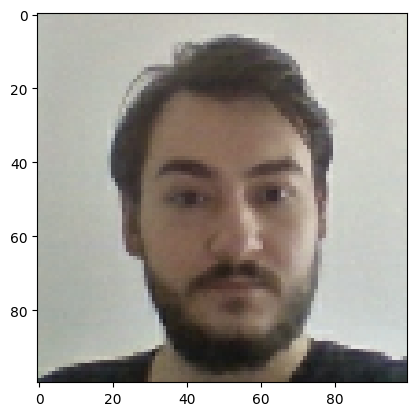

In [ ]:
plt.imshow(res[1])

In [ ]:
res[2]

1.0

In [ ]:
#Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [ ]:
#Training partition (taking 70% of all data for training)
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
#Testing partition (skipping the 70% we took for training and then testing on the other 30% of data)
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [ ]:
def make_embedding():
  inp = Input(shape=(100,100,3), name = 'input_image')

  #First block
  c1 = Conv2D(64, (10,10), activation = 'relu')(inp)
  m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

  #Second block
  c2 = Conv2D(128,(7,7), activation = 'relu')(m1)
  m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

  #Third block
  c3 = Conv2D(128, (4,4), activation = 'relu')(m2)
  m3 = MaxPooling2D(64, (2,2), padding = 'same')(c3)

  #Final embedding block
  c4 = Conv2D(256, (4,4), activation = 'relu')(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation = 'sigmoid')(f1)

  return Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
embedding = make_embedding()

In [ ]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class L1Dist(Layer):

  def __init__(self, **kwargs):
    super().__init__()

  def call(self, input_embedding, validation_embedding):
    # Debugging: Print types
    print(f"Input embedding type: {type(input_embedding)}")
    print(f"Validation embedding type: {type(validation_embedding)}")

    if isinstance(input_embedding, list):
        input_embedding = input_embedding[0]
    if isinstance(validation_embedding, list):
        validation_embedding = validation_embedding[0]

    input_embedding = tf.convert_to_tensor(input_embedding)
    validation_embedding = tf.convert_to_tensor(validation_embedding)

    return tf.math.abs(input_embedding - validation_embedding)



In [ ]:
l1 = L1Dist()

In [ ]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [ ]:
inp_embedding = embedding(input_image)  # Tensor of shape (batch_size, 4096)
val_embedding = embedding(validation_image)    # Tensor of shape (batch_size, 4096)

In [ ]:
siamese_layer = L1Dist()

In [ ]:
distances = siamese_layer(inp_embedding, val_embedding)

Input embedding type: <class 'list'>
Validation embedding type: <class 'list'>


In [ ]:
classifier = Dense(1, activation = 'sigmoid')(distances)

In [ ]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_12>

In [ ]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNewtork')

In [ ]:
siamese_network.summary()

Model: "SiameseNewtork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)    │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_img            │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │     38,960,448 │ input_img[0][0],       │
│                           │                        │                │ validation_img[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist_1 (L1Dist)        │ (None, 4096)           │              0 │ embedding[0][0],       │
│                           │                        │                │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │          4,097 │ l1_dist_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Making the Siamese Model
def make_siamese_model():

  #Anchor iamge input in the network
  input_image = Input(name='input_image', shape=(100,100,3))

  #Validation image in the network
  validation_image = Input(name='validation_img', shape=(100,100,3))

  #Combine siamese distance components
  siamese_layer = L1Dist()
  siamese_layer._name = 'distance'
  distances = siamese_layer(embedding(input_image), embedding(validation_image))

  #Clasification layer
  classifier = Dense(1, activation='sigmoid')(distances)

  return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')



In [ ]:
siamese_model = make_siamese_model()

Input embedding type: <class 'list'>
Validation embedding type: <class 'list'>


In [ ]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_img            │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │     38,960,448 │ input_image[0][0],     │
│                           │                        │                │ validation_img[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist_2 (L1Dist)        │ (None, 4096)           │              0 │ embedding[2][0],       │
│                           │                        │                │ embedding[3][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │          4,097 │ l1_dist_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [ ]:
opt = tf.keras.optimizers.Adam(0.0001)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)

In [ ]:
test_batch = train_data.as_numpy_iterator()

In [ ]:
batch_1 = test_batch.next()

In [ ]:
batch_1[2]

array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.],
      dtype=float32)

In [ ]:
X = batch_1[:2]

In [ ]:
y = batch_1[2]

In [ ]:
y

array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.],
      dtype=float32)

In [ ]:
@tf.function
def train_step(batch):

  #Record all of operations
  with tf.GradientTape() as tape:
    #Get anchor and positive/negative image
    X = batch[:2]
    #Get label
    y = batch[2]

    #Forward pass
    yhat = siamese_model(X, training=True)
    #Calculate loss
    loss = binary_cross_loss(y, yhat)
  print(loss)

  #Calculate gradients
  grad = tape.gradient(loss, siamese_model.trainable_variables)

  #Calculate updated weights and apply to siamese model
  opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

  #Return loss
  return loss

In [ ]:
#Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
def train(data, EPOCHS):
  #Loop through epochs
  for epoch in range(1, EPOCHS+1):
    print('\n Epoch {}/{}'.format(epoch, EPOCHS))
    progbar = tf.keras.utils.Progbar(len(data))

    #Creating a metric object
    r = Recall()
    p = Precision()

    #Loop through each batch
    for idx, batch in enumerate(data):
      #Run train step here
      loss = train_step(batch)
      yhat = siamese_model.predict(batch[:2])
      r.update_state(batch[2], yhat)
      p.update_state(batch[2], yhat)
      progbar.update(idx+1)
    print(loss.numpy(), r.result().numpy(), p.result().numpy())

    #Save checkpoints
    if epoch % 10 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
EPOCHS = 50

In [ ]:
train(train_data, EPOCHS)

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━

In [ ]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
y_hat = siamese_model.predict([test_input, test_val])

In [ ]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

In [ ]:
y_true

In [ ]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

In [ ]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

In [ ]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)

print(r.result().numpy(), p.result().numpy())

In [ ]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [ ]:
# Save weights
siamese_model.save('siamesemodelv2.h5')